### Load Model From Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!pip install -q "tensorflow==2.8.*"
!pip install -q "tensorflow-text==2.8.*"


In [13]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import pickle
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM
from tensorflow.keras import layers , activations , models , preprocessing , utils
from tensorflow.keras.models import load_model
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd

In [14]:
import tensorflow as tf
import tensorflow_text as text

In [15]:
import tensorflow as tf
tf.__version__

'2.8.3'

In [16]:
import tensorflow as tf

!pip install -q -U "tensorflow-text==2.8.*"


In [17]:
import tensorflow_text as text

In [18]:
!pip install fasttext
import fasttext.util

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 6.3 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3166353 sha256=6342c4aa533839cb0bf18141806219d874419b30435e4ddff04247b4514ea1d1
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


#Path of Saved Models

In [19]:
## Move to root directory
!ls
%cd drive/MyDrive/Machine\ Learning/GitHub\ Projects/machine-translation
!ls

## Move to models directory
%cd models/
!ls

drive  sample_data
/content/drive/MyDrive/Machine Learning/GitHub Projects/machine-translation
gitCommands.ipynb  models  notes.txt  README.md  test  train
/content/drive/MyDrive/Machine Learning/GitHub Projects/machine-translation/models
1000  10000  2908  5000


In [20]:
model_2908="2908/model.h5"
model_1000="1000/model.h5"
model_2909=""

In [21]:
path= "/content/drive/My Drive/Machine Learning/GitHub Projects/machine-translation/models/"

model_list=["10000"]
item=model_list[0]

model_path= path+item+"/model.h5" 
path_encoder_parameters= path+item+"/parameters/encoder_parameters.pickle" 
path_encoder_dictionary= path+item+"/dictionaries/encoder_dictionary.pickle" 
path_decoder_parameters= path+item+"/parameters/decoder_parameters.pickle" 
path_decoder_dictionary= path+item+"/dictionaries/decoder_dictionary.pickle" 
encoderPath= path+item+"/enc_model.h5" 
decoderPath= path+item+"/dec_model.h5" 

In [22]:
reconstructed_model = keras.models.load_model(model_path)
# plot_model(reconstructed_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)
# reconstructed_model.summary()


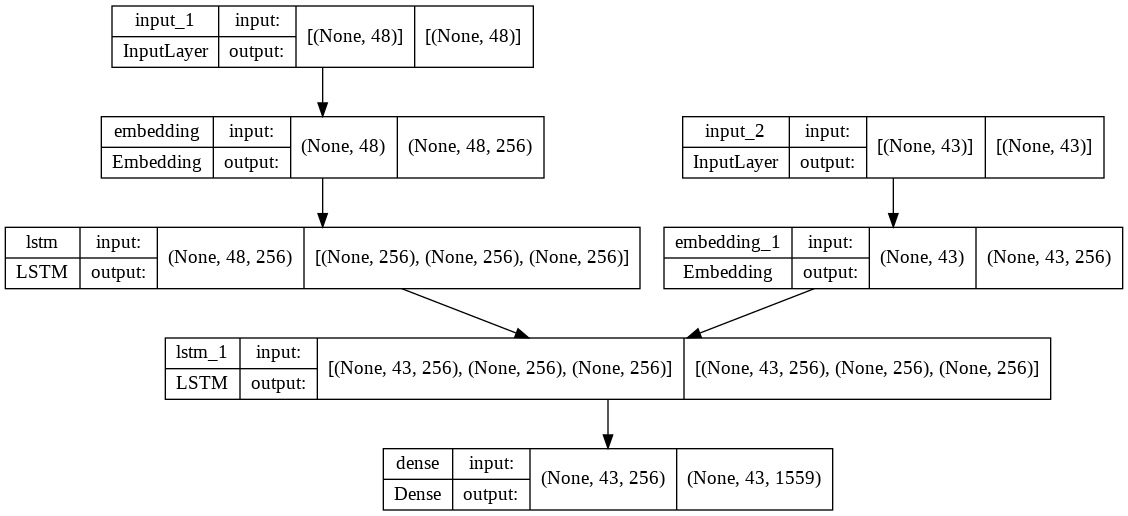

In [23]:

plot_model(reconstructed_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)

In [24]:
reconstructed_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 48, 256)      521728      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 43, 256)      399104      ['input_2[0][0]']                
                                                                                              

### Load Dictionaries and Parameters

In [25]:



# path_encoder_parameters='2908/parameters/encoder_parameters.pickle'
# path_encoder_dictionary='2908/dictionaries/encoder_dictionary.pickle'
# path_decoder_parameters='2908/parameters/decoder_parameters.pickle'
# path_decoder_dictionary='2908/dictionaries/decoder_dictionary.pickle'

# loading
with open(path_encoder_parameters, 'rb') as handle:
    encoder_parameters = pickle.load(handle)

# loading
with open(path_encoder_dictionary, 'rb') as handle:
    encoder_dictionary = pickle.load(handle)

# loading
with open(path_decoder_parameters, 'rb') as handle:
    decoder_parameters= pickle.load(handle)

# loading
with open(path_decoder_dictionary, 'rb') as handle:
    decoder_dictionary = pickle.load(handle)    


In [26]:
print(encoder_parameters)
# encoder_dictionary
print(decoder_parameters)
# decoder_dictionary

{'max_encoder_seq_length': 48, 'num_encoder_tokens': 2038}
{'max_decoder_seq_length': 43, 'num_decoder_tokens': 1559}


In [27]:
encoder_inputs = reconstructed_model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = reconstructed_model.layers[4].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)
latent_dim = 256  # Note: may be need to save in drive as well


In [28]:
num_decoder_tokens =decoder_parameters['num_decoder_tokens']
max_output_length= decoder_parameters['max_decoder_seq_length']
max_input_length= encoder_parameters['max_encoder_seq_length']

encoder_word_dict=encoder_dictionary
decoder_word_dict= decoder_dictionary

In [29]:

decoder_inputs = Input(shape=( max_output_length , ))
decoder_embedding = Embedding( num_decoder_tokens, 256 , mask_zero=True) (decoder_inputs)

decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
decoder_dense = Dense( num_decoder_tokens , activation=tf.keras.activations.softmax ) 


In [30]:
def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
          # print("word ", word, eng_word_dict.get(word,1) )
          my_word=  encoder_word_dict.get(word,1)
          tokens_list.append(my_word) 
  
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')


In [31]:

def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model


In [32]:
enc_model , dec_model = make_inference_models()

## Test Previous Model
Maybe we dont nedd the make infernece model and its attributes (above)

In [33]:



# encoderPath="2908/enc_model.h5" 
# decoderPath="2908/dec_model.h5"

# loading

enc_model =  load_model(encoderPath)


dec_model  =  load_model(decoderPath)

In [34]:
for epoch in range(1 ):
    states_values = enc_model.predict( str_to_tokens("ज़िन्दगी गुलज़ार है" ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = decoder_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in decoder_word_dict.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print("Decoded Traslation ", decoded_translation )
    # print(f"{bcolors.OKGREEN}Decoded Traslation: { decoded_translation}{bcolors.ENDC}")


Decoded Traslation   the class number of the function end


# BLEU Score

### Import Library

### Import Train Data: 
#### Calculte BLEU score on train data

Function to Translate English to Hindi

In [35]:
def translate_sentence(sentence):
  for epoch in range(1 ):
    states_values = enc_model.predict( str_to_tokens(sentence ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = decoder_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in decoder_word_dict.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print("Decoded Traslation ", decoded_translation )
  return  decoded_translation

Import Data 

In [36]:
!wget http://www.manythings.org/anki/hin-eng.zip -O hin-eng.zip
## IIT dataset : https://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/parallel.zip
!unzip hin-eng.zip

lines = pd.read_table( 'hin.txt' , names=[ 'eng' , 'hindi' ] )
lines.reset_index( level=0 , inplace=True )
lines.rename( columns={ 'index' : 'eng' , 'eng' : 'hindi' , 'hindi' : 'c' } , inplace=True )
lines = lines.drop( 'c' , 1 )



--2022-10-16 08:25:45--  http://www.manythings.org/anki/hin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131711 (129K) [application/zip]
Saving to: ‘hin-eng.zip’

hin-eng.zip         100%[===================>] 128.62K   855KB/s    in 0.2s    

2022-10-16 08:25:45 (855 KB/s) - ‘hin-eng.zip’ saved [131711/131711]

Archive:  hin-eng.zip
  inflating: hin.txt                 
  inflating: _about.txt              


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [37]:
lines.tail()

,eng,hindi
2904,"If you go to that supermarket, you can buy mos...",उस सूपरमार्केट में तुम लगभग कोई भी रोजाने में ...
2905,The passengers who were injured in the acciden...,जिन यात्रियों को दुर्घटना मे चोट आई थी उन्हे अ...
2906,"Democracy is the worst form of government, exc...","लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी..."
2907,If my boy had not been killed in the traffic a...,अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया...
2908,"When I was a kid, touching bugs didn't bother ...","जब मैं बच्चा था, मुझे कीड़ों को छूने से कोई पर..."


In [38]:
sample_sentences= lines[-10:]
sample_sentences

,eng,hindi
2899,Mother Teresa was a Catholic nun who lived and...,मदर टेरेसा एक कैथोलिक नन थीं जो कलकत्ता में रह...
2900,George Washington was the first president of t...,जार्ज वाशिंगटन संयुक्त राज्य अमेरिका के पहले र...
2901,"From my point of view, Australia is one of the...",मेरे नज़रिए से ऑस्ट्रेलिया विश्व के सर्व-श्रेष...
2902,"In 1951, Sister Teresa was sent to Calcutta, t...","१९५१ में सिस्टर टेरेसा को कलकत्ता भेजा गया था,..."
2903,Mother Teresa used the prize money for her wor...,"मदर टेरेसा को जो इनाम में पैसे मिले, उन्होंने ..."
2904,"If you go to that supermarket, you can buy mos...",उस सूपरमार्केट में तुम लगभग कोई भी रोजाने में ...
2905,The passengers who were injured in the acciden...,जिन यात्रियों को दुर्घटना मे चोट आई थी उन्हे अ...
2906,"Democracy is the worst form of government, exc...","लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी..."
2907,If my boy had not been killed in the traffic a...,अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया...
2908,"When I was a kid, touching bugs didn't bother ...","जब मैं बच्चा था, मुझे कीड़ों को छूने से कोई पर..."


In [39]:
sample_sentences.index

RangeIndex(start=2899, stop=2909, step=1)

### Reference Tokens

In [40]:
reference_tokens=[]

for line in sample_sentences['eng']:
   print( line.split() ) 
   reference_tokens.append( line.split() )

['Mother', 'Teresa', 'was', 'a', 'Catholic', 'nun', 'who', 'lived', 'and', 'worked', 'in', 'Calcutta,', 'India.']
['George', 'Washington', 'was', 'the', 'first', 'president', 'of', 'the', 'Unites', 'States', 'of', 'America.']
['From', 'my', 'point', 'of', 'view,', 'Australia', 'is', 'one', 'of', 'the', 'best', 'countries', 'in', 'the', 'world.']
['In', '1951,', 'Sister', 'Teresa', 'was', 'sent', 'to', 'Calcutta,', 'then', 'the', 'largest', 'city', 'in', 'India.']
['Mother', 'Teresa', 'used', 'the', 'prize', 'money', 'for', 'her', 'work', 'in', 'India', 'and', 'around', 'the', 'world.']
['If', 'you', 'go', 'to', 'that', 'supermarket,', 'you', 'can', 'buy', 'most', 'things', 'you', 'use', 'in', 'your', 'daily', 'life.']
['The', 'passengers', 'who', 'were', 'injured', 'in', 'the', 'accident', 'were', 'taken', 'to', 'the', 'nearest', 'hospital.']
['Democracy', 'is', 'the', 'worst', 'form', 'of', 'government,', 'except', 'all', 'the', 'others', 'that', 'have', 'been', 'tried.']
['If', 'my',

In [41]:
df = pd.DataFrame(      columns=['reference', 'candidate', 'bleu_score'],  )

df["reference"]= reference_tokens

df

,reference,candidate,bleu_score
0,"[Mother, Teresa, was, a, Catholic, nun, who, l...",NaN,NaN
1,"[George, Washington, was, the, first, presiden...",NaN,NaN
2,"[From, my, point, of, view,, Australia, is, on...",NaN,NaN
3,"[In, 1951,, Sister, Teresa, was, sent, to, Cal...",NaN,NaN
4,"[Mother, Teresa, used, the, prize, money, for,...",NaN,NaN
5,"[If, you, go, to, that, supermarket,, you, can...",NaN,NaN
6,"[The, passengers, who, were, injured, in, the,...",NaN,NaN
7,"[Democracy, is, the, worst, form, of, governme...",NaN,NaN
8,"[If, my, boy, had, not, been, killed, in, the,...",NaN,NaN
9,"[When, I, was, a, kid,, touching, bugs, didn't...",NaN,NaN


### Candidate Tokens

In [42]:
candidate_tokens=[]


for line in sample_sentences['hindi']:
   
   result= translate_sentence(line)
   temp =result.split()
   temp= temp[:-1]
   candidate_tokens.append(temp)
   

df["candidate"]= candidate_tokens

df

Decoded Traslation   the help for the four of diamonds next to the document end
Decoded Traslation   the help for the current line of the document end
Decoded Traslation   add the search and cards from the deck end
Decoded Traslation   the new bsd license see the copying and notice played the current layout end
Decoded Traslation   enter the selected based the selected text from the selected text to the clipboard end
Decoded Traslation   the name of the new bsd license see the current accessible of the current layout end
Decoded Traslation   move a onto the four of diamonds next to the four of diamonds end
Decoded Traslation   the four of the terms of the current layout for the current block end
Decoded Traslation   the search and search and attached version of the current buffer do you want to play end
Decoded Traslation   the name of the new card engine that allows many different played the current game you want to the default game klondike is being started end


,reference,candidate,bleu_score
0,"[Mother, Teresa, was, a, Catholic, nun, who, l...","[the, help, for, the, four, of, diamonds, next...",NaN
1,"[George, Washington, was, the, first, presiden...","[the, help, for, the, current, line, of, the, ...",NaN
2,"[From, my, point, of, view,, Australia, is, on...","[add, the, search, and, cards, from, the, deck]",NaN
3,"[In, 1951,, Sister, Teresa, was, sent, to, Cal...","[the, new, bsd, license, see, the, copying, an...",NaN
4,"[Mother, Teresa, used, the, prize, money, for,...","[enter, the, selected, based, the, selected, t...",NaN
5,"[If, you, go, to, that, supermarket,, you, can...","[the, name, of, the, new, bsd, license, see, t...",NaN
6,"[The, passengers, who, were, injured, in, the,...","[move, a, onto, the, four, of, diamonds, next,...",NaN
7,"[Democracy, is, the, worst, form, of, governme...","[the, four, of, the, terms, of, the, current, ...",NaN
8,"[If, my, boy, had, not, been, killed, in, the,...","[the, search, and, search, and, attached, vers...",NaN
9,"[When, I, was, a, kid,, touching, bugs, didn't...","[the, name, of, the, new, card, engine, that, ...",NaN


### Calculate BLEU Score for each Sentence

In [43]:


scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):
  
   result= sentence_bleu([reference], candidate)
   scores.append(result)
  #  print( result)
 

df["bleu_score"]= scores

df

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

,reference,candidate,bleu_score
0,"[Mother, Teresa, was, a, Catholic, nun, who, l...","[the, help, for, the, four, of, diamonds, next...",0.000000e+00
1,"[George, Washington, was, the, first, presiden...","[the, help, for, the, current, line, of, the, ...",4.828971e-155
2,"[From, my, point, of, view,, Australia, is, on...","[add, the, search, and, cards, from, the, deck]",5.370141e-232
3,"[In, 1951,, Sister, Teresa, was, sent, to, Cal...","[the, new, bsd, license, see, the, copying, an...",8.884136e-232
4,"[Mother, Teresa, used, the, prize, money, for,...","[enter, the, selected, based, the, selected, t...",1.042828e-231
5,"[If, you, go, to, that, supermarket,, you, can...","[the, name, of, the, new, bsd, license, see, t...",0.000000e+00
6,"[The, passengers, who, were, injured, in, the,...","[move, a, onto, the, four, of, diamonds, next,...",5.143564e-155
7,"[Democracy, is, the, worst, form, of, governme...","[the, four, of, the, terms, of, the, current, ...",1.082650e-231
8,"[If, my, boy, had, not, been, killed, in, the,...","[the, search, and, search, and, attached, vers...",8.038805e-232
9,"[When, I, was, a, kid,, touching, bugs, didn't...","[the, name, of, the, new, card, engine, that, ...",8.147480e-232


### Import Test Data: 
#### Calculate BLEU score on test data

# ROUGE Score

### Tensorflow Implementation

In [44]:
scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):
   temp =['captain', 'of', 'the', 'delta', 'flight']
   references =tf.ragged.constant([reference])
   hypotheses= tf.ragged.constant([candidate])

   result= text.metrics.rouge_l(hypotheses, references)
  
   result_str= " F-measure: "+str(result.f_measure.numpy()[0]) +"  Precision: "+str(result.p_measure.numpy()[0])+"  Recall: "+str(result.r_measure.numpy()[0])
   column=["f_measure", "p_measure", "r_measure"]
   data= [[result.f_measure.numpy()[0] ,result.p_measure.numpy()[0] , result.r_measure.numpy()[0] ]]
   metric= pd.DataFrame(data=data, columns=column)
   resultObj= {"f_measure": result.f_measure.numpy()[0] , "p_measure": result.p_measure.numpy()[0],  "r_measure":result.r_measure.numpy()[0] }  
   scores.append(resultObj)
 
 

df["rouge_score"]= scores

df

,reference,candidate,bleu_score,rouge_score
0,"[Mother, Teresa, was, a, Catholic, nun, who, l...","[the, help, for, the, four, of, diamonds, next...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur..."
1,"[George, Washington, was, the, first, presiden...","[the, help, for, the, current, line, of, the, ...",4.828971e-155,"{'f_measure': 0.28571427, 'p_measure': 0.33333..."
2,"[From, my, point, of, view,, Australia, is, on...","[add, the, search, and, cards, from, the, deck]",5.370141e-232,"{'f_measure': 0.17391306, 'p_measure': 0.25, '..."
3,"[In, 1951,, Sister, Teresa, was, sent, to, Cal...","[the, new, bsd, license, see, the, copying, an...",8.884136e-232,"{'f_measure': 0.07407408, 'p_measure': 0.07692..."
4,"[Mother, Teresa, used, the, prize, money, for,...","[enter, the, selected, based, the, selected, t...",1.042828e-231,"{'f_measure': 0.13793105, 'p_measure': 0.14285..."
5,"[If, you, go, to, that, supermarket,, you, can...","[the, name, of, the, new, bsd, license, see, t...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur..."
6,"[The, passengers, who, were, injured, in, the,...","[move, a, onto, the, four, of, diamonds, next,...",5.143564e-155,"{'f_measure': 0.22222222, 'p_measure': 0.23076..."
7,"[Democracy, is, the, worst, form, of, governme...","[the, four, of, the, terms, of, the, current, ...",1.082650e-231,"{'f_measure': 0.21428572, 'p_measure': 0.23076..."
8,"[If, my, boy, had, not, been, killed, in, the,...","[the, search, and, search, and, attached, vers...",8.038805e-232,"{'f_measure': 0.058823533, 'p_measure': 0.0625..."
9,"[When, I, was, a, kid,, touching, bugs, didn't...","[the, name, of, the, new, card, engine, that, ...",8.147480e-232,"{'f_measure': 0.04255319, 'p_measure': 0.04, '..."


In [45]:
# Example how to use ROUGE
hypotheses = tf.ragged.constant([['captain', 'of', 'the', 'delta', 'flight'],
                                ])
references = tf.ragged.constant([['delta', 'air', 'lines', 'flight'],
                                 ])


result = text.metrics.rouge_l(hypotheses, references)
result_str= " F-measure: "+str(result.f_measure.numpy()[0]) +"\n Precision: "+str(result.p_measure.numpy()[0])+"\n Recall: "+str(result.r_measure.numpy()[0])
print('F-Measure: %s' % result.f_measure)
print('P-Measure: %s' % result.p_measure)
print('R-Measure: %s' % result.r_measure)

F-Measure: tf.Tensor([0.44444448], shape=(1,), dtype=float32)
P-Measure: tf.Tensor([0.4], shape=(1,), dtype=float32)
R-Measure: tf.Tensor([0.5], shape=(1,), dtype=float32)


### PyPi Implementation ROUGE

In [46]:
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=5cd4d04153f12d5f4b670c5d5c649182136842a02ba6bf6256f1a69ebcaf495c
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [47]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [48]:
scores

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765),
 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}

In [49]:
scorer = rouge_scorer.RougeScorer([ 'rougeL'], use_stemmer=False)
scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):

   references = " ".join(reference)  
   hypotheses=  " ".join(candidate)
 
  
   result = scorer.score(references, hypotheses)

   scores.append(result)
 
 

df["py_pi_rouge_score"]= scores

df

# Not  working as I expected. It works if I use english letters, but the score is 0 if I test with sentence  which has hindi charachters

,reference,candidate,bleu_score,rouge_score,py_pi_rouge_score
0,"[Mother, Teresa, was, a, Catholic, nun, who, l...","[the, help, for, the, four, of, diamonds, next...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur...","{'rougeL': (0.0, 0.0, 0.0)}"
1,"[George, Washington, was, the, first, presiden...","[the, help, for, the, current, line, of, the, ...",4.828971e-155,"{'f_measure': 0.28571427, 'p_measure': 0.33333...","{'rougeL': (0.3333333333333333, 0.25, 0.285714..."
2,"[From, my, point, of, view,, Australia, is, on...","[add, the, search, and, cards, from, the, deck]",5.370141e-232,"{'f_measure': 0.17391306, 'p_measure': 0.25, '...","{'rougeL': (0.25, 0.13333333333333333, 0.17391..."
3,"[In, 1951,, Sister, Teresa, was, sent, to, Cal...","[the, new, bsd, license, see, the, copying, an...",8.884136e-232,"{'f_measure': 0.07407408, 'p_measure': 0.07692...","{'rougeL': (0.07692307692307693, 0.07142857142..."
4,"[Mother, Teresa, used, the, prize, money, for,...","[enter, the, selected, based, the, selected, t...",1.042828e-231,"{'f_measure': 0.13793105, 'p_measure': 0.14285...","{'rougeL': (0.14285714285714285, 0.13333333333..."
5,"[If, you, go, to, that, supermarket,, you, can...","[the, name, of, the, new, bsd, license, see, t...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur...","{'rougeL': (0.0, 0.0, 0.0)}"
6,"[The, passengers, who, were, injured, in, the,...","[move, a, onto, the, four, of, diamonds, next,...",5.143564e-155,"{'f_measure': 0.22222222, 'p_measure': 0.23076...","{'rougeL': (0.23076923076923078, 0.21428571428..."
7,"[Democracy, is, the, worst, form, of, governme...","[the, four, of, the, terms, of, the, current, ...",1.082650e-231,"{'f_measure': 0.21428572, 'p_measure': 0.23076...","{'rougeL': (0.23076923076923078, 0.2, 0.214285..."
8,"[If, my, boy, had, not, been, killed, in, the,...","[the, search, and, search, and, attached, vers...",8.038805e-232,"{'f_measure': 0.058823533, 'p_measure': 0.0625...","{'rougeL': (0.0625, 0.05555555555555555, 0.058..."
9,"[When, I, was, a, kid,, touching, bugs, didn't...","[the, name, of, the, new, card, engine, that, ...",8.147480e-232,"{'f_measure': 0.04255319, 'p_measure': 0.04, '...","{'rougeL': (0.04, 0.043478260869565216, 0.0416..."


### Cosine Score

Word Embedding Hindi

In [50]:

# fasttext.util.download_model('hi', if_exists='ignore')  # Hindi
fast_text_path='/content/drive/MyDrive/Machine Learning/FastText Hindi Word Embedding/cc.hi.300.bin'



In [51]:
ft = fasttext.load_model(fast_text_path)

Def. Cosine Score

In [52]:
def cos_sim(a, b):
	"""Takes 2 vectors a, b and returns the cosine similarity according 
	to the definition of the dot product
	"""
	dot_product = np.dot(a, b)
	norm_a = np.linalg.norm(a)
	norm_b = np.linalg.norm(b)
	return dot_product / (norm_a * norm_b)

In [53]:
scorer = cos_sim
scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):

   references = " ".join(reference)  
   hypotheses=  " ".join(candidate)
 
   references_vector  = ft.get_sentence_vector(references)
   hypotheses_vector  = ft.get_sentence_vector(hypotheses)

   result = scorer(references_vector, hypotheses_vector)

   scores.append(result)
 

df["cosine_similarity"]= scores

df

,reference,candidate,bleu_score,rouge_score,py_pi_rouge_score,cosine_similarity
0,"[Mother, Teresa, was, a, Catholic, nun, who, l...","[the, help, for, the, four, of, diamonds, next...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur...","{'rougeL': (0.0, 0.0, 0.0)}",0.715185
1,"[George, Washington, was, the, first, presiden...","[the, help, for, the, current, line, of, the, ...",4.828971e-155,"{'f_measure': 0.28571427, 'p_measure': 0.33333...","{'rougeL': (0.3333333333333333, 0.25, 0.285714...",0.834074
2,"[From, my, point, of, view,, Australia, is, on...","[add, the, search, and, cards, from, the, deck]",5.370141e-232,"{'f_measure': 0.17391306, 'p_measure': 0.25, '...","{'rougeL': (0.25, 0.13333333333333333, 0.17391...",0.801932
3,"[In, 1951,, Sister, Teresa, was, sent, to, Cal...","[the, new, bsd, license, see, the, copying, an...",8.884136e-232,"{'f_measure': 0.07407408, 'p_measure': 0.07692...","{'rougeL': (0.07692307692307693, 0.07142857142...",0.789618
4,"[Mother, Teresa, used, the, prize, money, for,...","[enter, the, selected, based, the, selected, t...",1.042828e-231,"{'f_measure': 0.13793105, 'p_measure': 0.14285...","{'rougeL': (0.14285714285714285, 0.13333333333...",0.800608
5,"[If, you, go, to, that, supermarket,, you, can...","[the, name, of, the, new, bsd, license, see, t...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur...","{'rougeL': (0.0, 0.0, 0.0)}",0.745793
6,"[The, passengers, who, were, injured, in, the,...","[move, a, onto, the, four, of, diamonds, next,...",5.143564e-155,"{'f_measure': 0.22222222, 'p_measure': 0.23076...","{'rougeL': (0.23076923076923078, 0.21428571428...",0.788322
7,"[Democracy, is, the, worst, form, of, governme...","[the, four, of, the, terms, of, the, current, ...",1.082650e-231,"{'f_measure': 0.21428572, 'p_measure': 0.23076...","{'rougeL': (0.23076923076923078, 0.2, 0.214285...",0.851728
8,"[If, my, boy, had, not, been, killed, in, the,...","[the, search, and, search, and, attached, vers...",8.038805e-232,"{'f_measure': 0.058823533, 'p_measure': 0.0625...","{'rougeL': (0.0625, 0.05555555555555555, 0.058...",0.817150
9,"[When, I, was, a, kid,, touching, bugs, didn't...","[the, name, of, the, new, card, engine, that, ...",8.147480e-232,"{'f_measure': 0.04255319, 'p_measure': 0.04, '...","{'rougeL': (0.04, 0.043478260869565216, 0.0416...",0.819892


In [54]:
# To Get nearest neigbours
# ft.get_nearest_neighbors("कीड़ों")
# ft.get_words()

In [55]:



rouge_metric= pd.DataFrame.from_records(df['rouge_score'])

average_f_measure = rouge_metric['f_measure'].mean()
average_p_measure = rouge_metric['p_measure'].mean()
average_r_measure = rouge_metric['r_measure'].mean()
average_cosine= df['cosine_similarity'].mean()
average_bleu= df['bleu_score'].mean()

print(
" F_measure: ",average_f_measure,
"\n P_measure: ",average_p_measure,
"\n R_measure: ",average_r_measure, 
"\n Cosine: ",average_cosine,
"\n BLEU: ",average_bleu
)


 F_measure:  0.12095173 
 P_measure:  0.1367152 
 R_measure:  0.110339105 
 Cosine:  0.79643 
 BLEU:  9.972534358242894e-156


In [56]:
table =pd.DataFrame(columns=["average_f_measure", "average_p_measure","average_r_measure", "average_cosine", "average_bleu"], data=[[average_f_measure, average_p_measure,average_r_measure, average_cosine, average_bleu]])
table

,average_f_measure,average_p_measure,average_r_measure,average_cosine,average_bleu
0,0.120952,0.136715,0.110339,0.79643,9.972534e-156


# Calculate Score 

In [57]:
def calculate_score(reconstructed_model, path_encoder_parameters,path_encoder_dictionary, path_decoder_parameters,path_decoder_dictionary):
    # loading
    print("Here")
    with open(path_encoder_parameters, 'rb') as handle:
        encoder_parameters = pickle.load(handle)

    # loading
    with open(path_encoder_dictionary, 'rb') as handle:
        encoder_dictionary = pickle.load(handle)

    # loading
    with open(path_decoder_parameters, 'rb') as handle:
        decoder_parameters= pickle.load(handle)

    # loading
    with open(path_decoder_dictionary, 'rb') as handle:
        decoder_dictionary = pickle.load(handle)    

    encoder_inputs = reconstructed_model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = reconstructed_model.layers[4].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, encoder_states)
    latent_dim = 256  # Note: may be need to save in drive as well

    num_decoder_tokens =decoder_parameters['num_decoder_tokens']
    max_output_length= decoder_parameters['max_decoder_seq_length']
    max_input_length= encoder_parameters['max_encoder_seq_length']

    encoder_word_dict=encoder_dictionary
    decoder_word_dict= decoder_dictionary

    decoder_inputs = Input(shape=( max_output_length , ))
    decoder_embedding = Embedding( num_decoder_tokens, 256 , mask_zero=True) (decoder_inputs)

    decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
    decoder_dense = Dense( num_decoder_tokens , activation=tf.keras.activations.softmax ) 

    def str_to_tokens( sentence : str ):
        words = sentence.lower().split()
        tokens_list = list()
        for word in words:
            # print("word ", word, eng_word_dict.get(word,1) )
            my_word=  encoder_word_dict.get(word,1)
            tokens_list.append(my_word) 
    
        return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')

        
    
    def make_inference_models():
        
        encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
        
        decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
        decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
        
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        
        decoder_outputs, state_h, state_c = decoder_lstm(
            decoder_embedding , initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        decoder_model = tf.keras.models.Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states)
        
        return encoder_model , decoder_model

    enc_model , dec_model = make_inference_models()
       
    for epoch in range(1 ):
        states_values = enc_model.predict( str_to_tokens("मुझे खाने से प्यार है" ) )
        empty_target_seq = np.zeros( ( 1 , 1 ) )
        empty_target_seq[0, 0] = decoder_word_dict['start']
        stop_condition = False
        decoded_translation = ''
        while not stop_condition :
            dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
            sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
            sampled_word = None
            for word , index in decoder_word_dict.items() :
                if sampled_word_index == index :
                    decoded_translation += ' {}'.format( word )
                    sampled_word = word
            
            if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
                stop_condition = True
                
            empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq[ 0 , 0 ] = sampled_word_index
            states_values = [ h , c ] 

        print("Decoded Traslation ", decoded_translation )
            
    return "Good"


In [58]:
calculate_score(reconstructed_model, path_encoder_parameters,path_encoder_dictionary, path_decoder_parameters,path_decoder_dictionary)

Here


Decoded Traslation   arguments i i parenth parenth parenth parenth opened opened parenth opened node ompile node settings remove… node settings remove… yield settings remove… main selector selector selector percentage screen assoc name detach ap percentage assoc rounds rule hyperlink manager than i value value value items


'Good'

In [59]:
!ls


1000  10000  2908  5000
